In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import lightgbm as lgb

In [2]:
scenarios = {"optimistic":"ssp1_2_6",
             "neutral":"ssp2_4_5",
             "pessimistic":"ssp5_8_5"}

In [3]:
df_area = pd.read_csv(r"..\data\barley_yield_from_1982.csv", sep=';')

In [4]:
last_area = df_area.dropna(subset=["area"]).sort_values("year").groupby("department").last()[["area"]].reset_index()
last_area.head()

,department,area
0,Ain,8870.0
1,Aisne,47790.0
2,Allier,13780.0
3,Alpes_Maritimes,10.0
4,Alpes_de_Haute_Provence,3453.0


In [5]:
s = 'optimistic'
scenario = scenarios[s]
df = pd.read_csv(f"../data/weather_agg_{scenario}.csv")
df = df.dropna(subset=["mean_max_temp", "std_max_temp", "std_precip"])

In [6]:
df.sort_values("year", ascending = True)

,scenario,department,code_dep,year,mean_temp,std_temp,mean_max_temp,std_max_temp,total_precip,std_precip,yield
0,historical,Ain,1,1982,282.77924,7.090540,287.48267,8.055373,0.027494,0.000120,3.950078
2574,historical,Somme,80,1982,283.59534,6.709761,287.07242,7.748220,0.028498,0.000128,6.037931
594,historical,Correze,19,1982,282.33575,6.604024,286.93512,7.655155,0.065636,0.000277,2.363158
627,historical,Cote_d_Or,21,1982,282.69196,7.265679,287.25403,8.291865,0.043310,0.000184,4.447979
2541,historical,Seine_et_Marne,77,1982,283.99490,7.501804,288.43646,8.690378,0.007367,0.000040,5.697143
...,...,...,...,...,...,...,...,...,...,...,...
3980,ssp1_2_6,Eure_et_Loir,28,2050,285.22110,6.803133,289.15570,7.692380,0.036134,0.000164,NaN
3188,ssp1_2_6,Ardennes,8,2050,284.22546,6.851576,288.13013,7.848469,0.024687,0.000107,NaN
5708,ssp1_2_6,Seine_Maritime,76,2050,284.93118,6.034536,288.16920,6.794929,0.033093,0.000158,NaN
4196,ssp1_2_6,Haute_Garonne,31,2050,286.33957,6.437269,291.23083,7.053396,0.032264,0.000166,NaN


In [7]:
df.head()

,scenario,department,code_dep,year,mean_temp,std_temp,mean_max_temp,std_max_temp,total_precip,std_precip,yield
0,historical,Ain,1,1982,282.77924,7.090540,287.48267,8.055373,0.027494,0.000120,3.950078
1,historical,Ain,1,1983,281.72400,7.357678,286.23380,8.096182,0.029012,0.000119,2.648276
2,historical,Ain,1,1984,282.05420,6.998279,286.64294,8.002853,0.027781,0.000125,4.822581
3,historical,Ain,1,1985,281.67966,7.407989,286.12997,8.244929,0.034206,0.000145,4.196774
4,historical,Ain,1,1986,282.42148,6.688269,287.31296,7.404187,0.023955,0.000116,3.598450


In [8]:
df_train = df[df["year"]<2015]
df_val = df[(df["year"]<2019) & (df["year"]>=2015)]
df_test = df[df["year"]>=2019]

In [9]:
df_train.shape, df_val.shape, df_test.shape

((2937, 11), (356, 11), (2848, 11))

In [10]:
meta_val = df_val[["year", "department"]].reset_index(drop=True)

X_train = df_train.drop(columns = ["scenario", "year","yield"])
X_val = df_val.drop(columns = ["scenario", "year","yield"])
X_test = df_test.drop(columns = ["scenario", "year","yield"])
y_train = df_train["yield"]
y_val = df_val["yield"]

In [11]:
X_train.head()

,department,code_dep,mean_temp,std_temp,mean_max_temp,std_max_temp,total_precip,std_precip
0,Ain,1,282.77924,7.090540,287.48267,8.055373,0.027494,0.000120
1,Ain,1,281.72400,7.357678,286.23380,8.096182,0.029012,0.000119
2,Ain,1,282.05420,6.998279,286.64294,8.002853,0.027781,0.000125
3,Ain,1,281.67966,7.407989,286.12997,8.244929,0.034206,0.000145
4,Ain,1,282.42148,6.688269,287.31296,7.404187,0.023955,0.000116


In [12]:
cat_col = ["department"]
num_col = X_train.select_dtypes(include="number").columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_col),
        ("num", StandardScaler(), num_col),
    ],
    remainder="passthrough",
).set_output(transform="pandas")

# Define models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1, max_iter=5000),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=200, max_depth=5, learning_rate=0.1, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, verbosity=-1),
    "SVR": SVR(kernel="rbf", C=1.0, epsilon=0.1),
    "MLP": MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, learning_rate_init=0.001, random_state=42, early_stopping=True),
}

results = []

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    pipe.fit(X_train, y_train)
    y_pred_val = pipe.predict(X_val)
    
    r2 = r2_score(y_val, y_pred_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    mape = mean_absolute_percentage_error(y_val, y_pred_val)
    
    results.append({"Model": name, "R²": round(r2, 4), "MAE": round(mae, 4), "MAPE": round(mape, 4)})
    print(f"{name:25s} | R²={r2:.4f} | MAE={mae:.4f} | MAPE={mape:.4f}")

results_df = pd.DataFrame(results).sort_values("R²", ascending=False).reset_index(drop=True)
results_df

Linear Regression         | R²=0.6163 | MAE=0.6193 | MAPE=0.1075
Ridge                     | R²=0.5990 | MAE=0.6423 | MAPE=0.1104
Lasso                     | R²=-0.0309 | MAE=1.0019 | MAPE=0.1737
Decision Tree             | R²=0.3391 | MAE=0.8118 | MAPE=0.1422
Random Forest             | R²=0.4712 | MAE=0.7480 | MAPE=0.1270
Gradient Boosting         | R²=0.5530 | MAE=0.6879 | MAPE=0.1203
HistGradientBoosting      | R²=0.5493 | MAE=0.6911 | MAPE=0.1198
LightGBM                  | R²=0.5462 | MAE=0.6914 | MAPE=0.1199
SVR                       | R²=0.6346 | MAE=0.6225 | MAPE=0.1084
MLP                       | R²=0.5370 | MAE=0.6984 | MAPE=0.1224


,Model,R²,MAE,MAPE
0,SVR,0.6346,0.6225,0.1084
1,Linear Regression,0.6163,0.6193,0.1075
2,Ridge,0.5990,0.6423,0.1104
3,Gradient Boosting,0.5530,0.6879,0.1203
4,HistGradientBoosting,0.5493,0.6911,0.1198
5,LightGBM,0.5462,0.6914,0.1199
6,MLP,0.5370,0.6984,0.1224
7,Random Forest,0.4712,0.7480,0.1270
8,Decision Tree,0.3391,0.8118,0.1422
9,Lasso,-0.0309,1.0019,0.1737


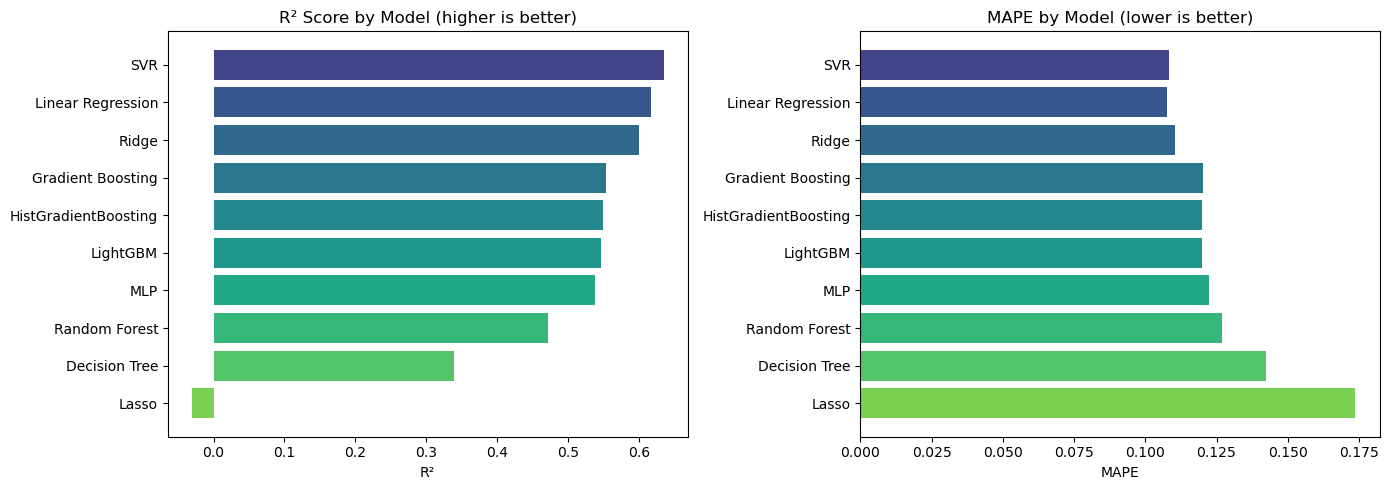

In [13]:
# Visualise R² and MAPE side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(results_df)))

# R² bar chart
axes[0].barh(results_df["Model"], results_df["R²"], color=colors)
axes[0].set_xlabel("R²")
axes[0].set_title("R² Score by Model (higher is better)")
axes[0].invert_yaxis()

# MAPE bar chart
axes[1].barh(results_df["Model"], results_df["MAPE"], color=colors)
axes[1].set_xlabel("MAPE")
axes[1].set_title("MAPE by Model (lower is better)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [14]:
# Refit the best model for further analysis
best_model_name = results_df.loc[0, "Model"]
print(f"Best model: {best_model_name}")

best_model = models[best_model_name]
best_pipe = make_pipeline(preprocessor, best_model)
best_pipe.fit(X_train, y_train)
y_pred_val = best_pipe.predict(X_val)

r2 = r2_score(y_val, y_pred_val)
mae = mean_absolute_error(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
print(f"R²  = {r2:.4f}")
print(f"MAE = {mae:.4f}")
print(f"MAPE = {mape:.4f}")

Best model: SVR
R²  = 0.6346
MAE = 0.6225
MAPE = 0.1084


In [15]:
lr = LinearRegression()
lr_pipe = make_pipeline(preprocessor, lr)
lr_pipe.fit(X_train, y_train)
y_pred_svr = lr_pipe.predict(X_val)

r2 = r2_score(y_val, y_pred_svr)
mae = mean_absolute_error(y_val, y_pred_svr)
mape = mean_absolute_percentage_error(y_val, y_pred_svr)
print(f"Tuned SVR — R²={r2:.4f} | MAE={mae:.4f} | MAPE={mape:.4f}")

Tuned SVR — R²=0.6163 | MAE=0.6193 | MAPE=0.1075


In [16]:
pred_val_df = pd.DataFrame({
    "year": df_val["year"].values,
    "department": df_val["department"].values,
    "actual_yield": y_val.values,
    "predicted_yield": y_pred_svr
})


Let's look at our prediction for a specific region

In [17]:
region_choice = "Yvelines"

In [18]:
region_perf = pred_val_df[
    pred_val_df["department"] == region_choice
].reset_index()

region_perf = (
    region_perf
    .groupby("year")
    .agg(
        actual=("actual_yield","mean"),
        predicted=("predicted_yield","mean")
    )
    .reset_index()
)



In [19]:

fig_perf = px.line(
    region_perf,
    x="year",
    y=["actual","predicted"],
    markers=True,
    title=f"Actual vs Predicted Yield in {region_choice}"
)

fig_perf.show()

In [20]:
df_opt = pd.concat([df_val, df_test], axis=0)

df_opt["predicted_yield"] = lr_pipe.predict(pd.concat([X_val, X_test], axis=0))

In [21]:
scenario = scenarios['neutral']
df = pd.read_csv(f"../data/weather_agg_{scenario}.csv")
df = df.dropna(subset=["mean_max_temp", "std_max_temp", "std_precip"])

In [22]:
df_neu = df[df['scenario'] == scenario]

In [23]:
scenario = scenarios['pessimistic']
df = pd.read_csv(f"../data/weather_agg_{scenario}.csv")
df = df.dropna(subset=["mean_max_temp", "std_max_temp", "std_precip"])

In [24]:
df_pes = df[df['scenario'] == scenario]

In [25]:
X_neu = df_neu.drop(columns = ["scenario", "year","yield"])
X_pes = df_pes.drop(columns = ["scenario", "year","yield"])

In [26]:
df_neu["predicted_yield"] = lr_pipe.predict(X_neu)
df_pes["predicted_yield"] = lr_pipe.predict(X_pes)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20760\2195669789.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
neu_val = df_neu[df_neu["year"]<2019]
r2 = r2_score(neu_val["predicted_yield"], neu_val["yield"])
mae = mean_absolute_error(neu_val["yield"], neu_val["predicted_yield"])
mape = mean_absolute_percentage_error(neu_val["yield"], neu_val["predicted_yield"])
print(f"Neutral scenario — R²={r2:.4f} | MAE={mae:.4f} | MAPE={mape:.4f}")

Neutral scenario — R²=-0.4121 | MAE=2.9283 | MAPE=0.5828


In [28]:
pes_val = df_pes[df_pes["year"]<2019]
r2 = r2_score(pes_val["predicted_yield"], pes_val["yield"])
mae = mean_absolute_error(pes_val["yield"], pes_val["predicted_yield"])
mape = mean_absolute_percentage_error(pes_val["yield"], pes_val["predicted_yield"])
print(f"Prescriptive scenario — R²={r2:.4f} | MAE={mae:.4f} | MAPE={mape:.4f}")

Prescriptive scenario — R²=0.4966 | MAE=0.6464 | MAPE=0.1156


In [29]:
# Combine optimistic and pessimistic scenarios for comparison
df_opt_plot = df_opt[["year", "department", "predicted_yield"]].copy()
df_opt_plot["scenario"] = "Optimistic (SSP1-2.6)"

df_pes_plot = df_pes[["year", "department", "predicted_yield"]].copy()
df_pes_plot["scenario"] = "Pessimistic (SSP5-8.5)"

df_all = pd.concat([df_opt_plot, df_pes_plot], ignore_index=True)

# Merge with last known area per department and compute production
df_all = df_all.merge(last_area, on="department", how="left")
df_all["predicted_production"] = df_all["predicted_yield"] * df_all["area"]

In [30]:
# 1. Total predicted production per year across scenarios
total_by_year = (
    df_all
    .groupby(["year", "scenario"])["predicted_production"]
    .sum()
    .reset_index()
)

fig1 = px.line(
    total_by_year,
    x="year",
    y="predicted_production",
    color="scenario",
    markers=True,
    title="Total Predicted Barley Production per Year: Optimistic vs Pessimistic",
    labels={"predicted_production": "Total Predicted Production", "year": "Year"},
    color_discrete_map={
        "Optimistic (SSP1-2.6)": "#2ecc71",
        "Pessimistic (SSP5-8.5)": "#e74c3c",
    },
)
fig1.update_layout(legend_title_text="Scenario")
fig1.show()

In [31]:
# 2. Average predicted production per year across scenarios
avg_by_year = (
    df_all
    .groupby(["year", "scenario"])["predicted_production"]
    .mean()
    .reset_index()
)

fig2 = px.line(
    avg_by_year,
    x="year",
    y="predicted_production",
    color="scenario",
    markers=True,
    title="Average Predicted Barley Production per Year: Optimistic vs Pessimistic",
    labels={"predicted_production": "Avg Predicted Production", "year": "Year"},
    color_discrete_map={
        "Optimistic (SSP1-2.6)": "#2ecc71",
        "Pessimistic (SSP5-8.5)": "#e74c3c",
    },
)
fig2.update_layout(legend_title_text="Scenario")
fig2.show()

In [32]:
# 3. Distribution of predicted production by scenario (box plot)
fig3 = px.box(
    df_all,
    x="scenario",
    y="predicted_production",
    color="scenario",
    title="Distribution of Predicted Production: Optimistic vs Pessimistic",
    labels={"predicted_production": "Predicted Production", "scenario": "Scenario"},
    color_discrete_map={
        "Optimistic (SSP1-2.6)": "#2ecc71",
        "Pessimistic (SSP5-8.5)": "#e74c3c",
    },
)
fig3.update_layout(showlegend=False)
fig3.show()

In [50]:
# 4. Scenario comparison for a specific department
dept_choice = "Mayenne"

dept_df = df_all[df_all["department"] == dept_choice]
dept_agg = (
    dept_df
    .groupby(["year", "scenario"])["predicted_production"]
    .mean()
    .reset_index()
)

fig4 = px.line(
    dept_agg,
    x="year",
    y="predicted_production",
    color="scenario",
    markers=True,
    title=f"Predicted Production in {dept_choice}: Optimistic vs Pessimistic",
    labels={"predicted_production": "Predicted Production", "year": "Year"},
    color_discrete_map={
        "Optimistic (SSP1-2.6)": "#2ecc71",
        "Pessimistic (SSP5-8.5)": "#e74c3c",
    },
)
fig4.update_layout(legend_title_text="Scenario")
fig4.show()

In [34]:
# 5. Percentage change in average production: Pessimistic vs Optimistic by department
avg_dept = (
    df_all
    .groupby(["department", "scenario"])["predicted_production"]
    .mean()
    .reset_index()
)

pivot = avg_dept.pivot(index="department", columns="scenario", values="predicted_production")
pivot["Pessimistic vs Optimistic (%)"] = (
    (pivot["Pessimistic (SSP5-8.5)"] - pivot["Optimistic (SSP1-2.6)"]) / pivot["Optimistic (SSP1-2.6)"] * 100
)

change_df = pivot[["Pessimistic vs Optimistic (%)"]].reset_index()

fig5 = px.bar(
    change_df.sort_values("Pessimistic vs Optimistic (%)"),
    x="Pessimistic vs Optimistic (%)",
    y="department",
    orientation="h",
    title="% Change in Avg Predicted Production: Pessimistic vs Optimistic by Department",
    labels={"department": "Department", "Pessimistic vs Optimistic (%)": "Change (%)"},
    color="Pessimistic vs Optimistic (%)",
    color_continuous_scale=["#e74c3c", "#f39c12", "#2ecc71"],
    height=800,
)
fig5.update_layout(yaxis={"categoryorder": "total ascending"})
fig5.show()

## Deep Dive: Years Where Optimistic >> Pessimistic (2027, 2030, 2035)
Which departments are most resilient (smallest yield drop) in these specific years?

In [52]:
# Filter for selected years and compute % drop per department
focus_years = [2027, 2030, 2035]

df_focus = df_all[df_all["year"].isin(focus_years)].copy()

# Pivot to get opt vs pes side by side
focus_pivot = df_focus.pivot_table(
    index=["year", "department"],
    columns="scenario",
    values="predicted_production",
).reset_index()

focus_pivot.columns.name = None
focus_pivot["drop_pct"] = (
    (focus_pivot["Pessimistic (SSP5-8.5)"] - focus_pivot["Optimistic (SSP1-2.6)"])
    / focus_pivot["Optimistic (SSP1-2.6)"] * 100
)

# Summary stats per year
for yr in focus_years:
    sub = focus_pivot[focus_pivot["year"] == yr]
    print(f"\n--- {yr} ---")
    print(f"  Avg drop: {sub['drop_pct'].mean():.2f}%")
    print(f"  Median drop: {sub['drop_pct'].median():.2f}%")
    print(f"  Max drop: {sub['drop_pct'].min():.2f}%")
    print(f"  Min drop (most resilient): {sub['drop_pct'].max():.2f}%")


--- 2027 ---
  Avg drop: -14.36%
  Median drop: -14.57%
  Max drop: -25.04%
  Min drop (most resilient): -7.33%

--- 2030 ---
  Avg drop: -4.08%
  Median drop: -3.26%
  Max drop: -20.94%
  Min drop (most resilient): 7.79%

--- 2035 ---
  Avg drop: -13.37%
  Median drop: -13.36%
  Max drop: -21.77%
  Min drop (most resilient): -7.19%


In [55]:
# Grouped bar chart: % production drop per department for each year
fig_drop = px.bar(
    focus_pivot.sort_values(["year", "drop_pct"]),
    x="department",
    y="drop_pct",
    color="year",
    facet_row="year",
    title="% Production Drop (Pessimistic vs Optimistic) by Department — 2027, 2030, 2035",
    labels={"drop_pct": "Production Change (%)", "department": "Department"},
    color_discrete_sequence=["#3498db", "#f39c12", "#9b59b6"],
    height=900,
)
fig_drop.update_xaxes(tickangle=-90, tickfont_size=8)
fig_drop.update_layout(showlegend=False)
fig_drop.show()

In [56]:
# Top 10 most resilient departments (smallest drop) per year
for yr in focus_years:
    sub = focus_pivot[focus_pivot["year"] == yr].sort_values("drop_pct", ascending=False).head(10)
    print(f"\n=== {yr}: Top 10 Most Resilient Departments ===")
    for _, row in sub.iterrows():
        print(f"  {row['department']:25s} | Opt: {row['Optimistic (SSP1-2.6)']:12.0f} | Pes: {row['Pessimistic (SSP5-8.5)']:12.0f} | Change: {row['drop_pct']:+.2f}%")


=== 2027: Top 10 Most Resilient Departments ===
  Seine_Maritime            | Opt:       202127 | Pes:       187302 | Change: -7.33%
  Eure                      | Opt:       256845 | Pes:       237189 | Change: -7.65%
  Eure_et_Loir              | Opt:       516570 | Pes:       476482 | Change: -7.76%
  Cotes_d_Armor             | Opt:       196602 | Pes:       180740 | Change: -8.07%
  Calvados                  | Opt:       140250 | Pes:       128758 | Change: -8.19%
  Yvelines                  | Opt:        95431 | Pes:        87204 | Change: -8.62%
  Orne                      | Opt:       163399 | Pes:       149307 | Change: -8.62%
  Vendee                    | Opt:        53683 | Pes:        48908 | Change: -8.90%
  Finistere                 | Opt:       184955 | Pes:       168424 | Change: -8.94%
  Pas_de_Calais             | Opt:       261870 | Pes:       238431 | Change: -8.95%

=== 2030: Top 10 Most Resilient Departments ===
  Lot_et_Garonne            | Opt:        32958 | Pe

In [51]:
# Top 10 worst resilient departments (smallest drop) per year
for yr in focus_years:
    sub = focus_pivot[focus_pivot["year"] == yr].sort_values("drop_pct", ascending=True).head(10)
    print(f"\n=== {yr}: Top 10 Worst Resilient Departments ===")
    for _, row in sub.iterrows():
        print(f"  {row['department']:25s} | Opt: {row['Optimistic (SSP1-2.6)']:12.0f} | Pes: {row['Pessimistic (SSP5-8.5)']:12.0f} | Change: {row['drop_pct']:+.2f}%")


=== 2017: Top 10 Worst Resilient Departments ===
  Pyrenees_Orientales       | Opt:          324 | Pes:          264 | Change: -18.52%
  Lozere                    | Opt:        11066 | Pes:         9212 | Change: -16.75%
  Tarn                      | Opt:       102306 | Pes:        86172 | Change: -15.77%
  Herault                   | Opt:         5259 | Pes:         4540 | Change: -13.67%
  Meurthe_et_Moselle        | Opt:       239915 | Pes:       210449 | Change: -12.28%
  Aveyron                   | Opt:       114081 | Pes:       100078 | Change: -12.27%
  Correze                   | Opt:         6543 | Pes:         5743 | Change: -12.23%
  Moselle                   | Opt:       241692 | Pes:       212205 | Change: -12.20%
  Aude                      | Opt:        23168 | Pes:        20381 | Change: -12.03%
  Vosges                    | Opt:        69670 | Pes:        61433 | Change: -11.82%

=== 2024: Top 10 Worst Resilient Departments ===
  Alpes_Maritimes           | Opt:      

In [38]:
# Heatmap: % production drop across departments × years
heatmap_data = focus_pivot.pivot_table(
    index="department", columns="year", values="drop_pct"
).sort_values(focus_years[-1], ascending=False)

fig_heat = px.imshow(
    heatmap_data,
    color_continuous_scale="RdYlGn",
    aspect="auto",
    title="Production Change (%) Pessimistic vs Optimistic by Department & Year",
    labels={"color": "Change (%)"},
    height=900,
)
fig_heat.update_xaxes(dtick=1)
fig_heat.show()

In [39]:
# Side-by-side absolute production comparison for focus years
fig_abs = px.bar(
    df_focus.sort_values(["year", "department"]),
    x="department",
    y="predicted_production",
    color="scenario",
    facet_row="year",
    barmode="group",
    title="Predicted Production by Department: Optimistic vs Pessimistic — 2017, 2024, 2027",
    labels={"predicted_production": "Predicted Production", "department": "Department"},
    color_discrete_map={
        "Optimistic (SSP1-2.6)": "#2ecc71",
        "Pessimistic (SSP5-8.5)": "#e74c3c",
    },
    height=900,
)
fig_abs.update_xaxes(tickangle=-90, tickfont_size=8)
fig_abs.show()

## Top 4 Largest Departments: Performance & Resilience
Focus on the 4 departments with the largest barley area to compare production trajectories and scenario resilience.

In [46]:
# Identify top 4 departments by area
top4 = last_area.nlargest(4, "area")
top4_names = top4["department"].tolist()
print("Top 4 largest departments by area:")
print(top4.to_string(index=False))

# Filter df_all for these departments
df_top4 = df_all[df_all["department"].isin(top4_names)].copy()

Top 4 largest departments by area:
department     area
     Marne 102650.0
      Aube  88050.0
     Yonne  78610.0
    Loiret  68490.0


In [47]:
# Production over time for each top-4 department (Optimistic vs Pessimistic)
fig_top4_prod = px.line(
    df_top4.groupby(["year", "department", "scenario"])["predicted_production"].sum().reset_index(),
    x="year",
    y="predicted_production",
    color="scenario",
    facet_col="department",
    facet_col_wrap=2,
    markers=True,
    title="Predicted Production Over Time — Top 4 Largest Departments",
    labels={"predicted_production": "Predicted Production", "year": "Year"},
    color_discrete_map={
        "Optimistic (SSP1-2.6)": "#2ecc71",
        "Pessimistic (SSP5-8.5)": "#e74c3c",
    },
    height=600,
)
fig_top4_prod.update_layout(legend_title_text="Scenario")
fig_top4_prod.show()

In [48]:
# Resilience: % change Pessimistic vs Optimistic per year for top 4
top4_pivot = df_top4.pivot_table(
    index=["year", "department"],
    columns="scenario",
    values="predicted_production",
).reset_index()
top4_pivot.columns.name = None
top4_pivot["change_pct"] = (
    (top4_pivot["Pessimistic (SSP5-8.5)"] - top4_pivot["Optimistic (SSP1-2.6)"])
    / top4_pivot["Optimistic (SSP1-2.6)"] * 100
)

fig_top4_resil = px.line(
    top4_pivot,
    x="year",
    y="change_pct",
    color="department",
    markers=True,
    title="Resilience: % Production Change (Pessimistic vs Optimistic) — Top 4 Largest Departments",
    labels={"change_pct": "Production Change (%)", "year": "Year"},
    height=500,
)
fig_top4_resil.update_layout(legend_title_text="Department")
fig_top4_resil.add_hline(y=0, line_dash="dash", line_color="grey")
fig_top4_resil.show()

In [49]:
# Summary table: average production & resilience for top 4 departments
top4_summary = top4_pivot.groupby("department").agg(
    avg_opt=("Optimistic (SSP1-2.6)", "mean"),
    avg_pes=("Pessimistic (SSP5-8.5)", "mean"),
    avg_change_pct=("change_pct", "mean"),
    worst_change_pct=("change_pct", "min"),
).reset_index()
top4_summary.columns = ["Department", "Avg Optimistic Prod", "Avg Pessimistic Prod", "Avg Change (%)", "Worst Change (%)"]
top4_summary = top4_summary.sort_values("Avg Change (%)", ascending=True)

fig_top4_bar = px.bar(
    top4_summary,
    x="Department",
    y=["Avg Change (%)", "Worst Change (%)"],
    barmode="group",
    title="Resilience Summary — Top 4 Largest Departments",
    labels={"value": "Change (%)", "variable": "Metric"},
    color_discrete_map={"Avg Change (%)": "#f39c12", "Worst Change (%)": "#e74c3c"},
    height=450,
)
fig_top4_bar.add_hline(y=0, line_dash="dash", line_color="grey")
fig_top4_bar.show()

print(top4_summary.to_string(index=False))

Department  Avg Optimistic Prod  Avg Pessimistic Prod  Avg Change (%)  Worst Change (%)
      Aube        669470.002269         671937.080533        0.537816        -14.127141
     Yonne        519411.279784         522103.554786        0.727835        -14.872630
    Loiret        466144.849984         468783.176963        0.760517        -12.910109
     Marne        796691.583628         805020.551831        1.188708        -13.473851


## 2025–2035: Production vs Resilience Matrix
Scatter plot of all departments on two dimensions:
- **X-axis**: Average predicted production (optimistic scenario, 2025-2035)
- **Y-axis**: Resilience = average % change pessimistic vs optimistic (closer to 0 = more resilient)

Departments in the **top-right quadrant** (high production + high resilience) are the most attractive.

In [71]:
# Filter 2025-2035
df_2530 = df_all[(df_all["year"] >= 2025) & (df_all["year"] <= 2035)].copy()

# Pivot optimistic vs pessimistic production per department × year
matrix_pivot = df_2530.pivot_table(
    index=["year", "department"],
    columns="scenario",
    values="predicted_production",
).reset_index()
matrix_pivot.columns.name = None

matrix_pivot["change_pct"] = (
    (matrix_pivot["Pessimistic (SSP5-8.5)"] - matrix_pivot["Optimistic (SSP1-2.6)"])
    / matrix_pivot["Optimistic (SSP1-2.6)"] * 100
)

# Aggregate per department: avg optimistic production & avg resilience
matrix_dept = matrix_pivot.groupby("department").agg(
    avg_production=("Optimistic (SSP1-2.6)", "mean"),
    avg_resilience=("change_pct", "mean"),
).reset_index()

# Define quadrant thresholds (medians)
prod_median = matrix_dept["avg_production"].median()
resil_median = matrix_dept["avg_resilience"].median()

# Label quadrants
def quadrant(row):
    if row["avg_production"] >= prod_median and row["avg_resilience"] >= resil_median:
        return "High Production & High Resilience"
    elif row["avg_production"] >= prod_median and row["avg_resilience"] < resil_median:
        return "High Production & Low Resilience"
    elif row["avg_production"] < prod_median and row["avg_resilience"] >= resil_median:
        return "Low Production & High Resilience"
    else:
        return "Low Production & Low Resilience"

matrix_dept["quadrant"] = matrix_dept.apply(quadrant, axis=1)

print(f"Production median: {prod_median:,.0f}")
print(f"Resilience median: {resil_median:.2f}%")
print(f"\nHigh Production & High Resilience departments:")
best = matrix_dept[matrix_dept["quadrant"] == "High Production & High Resilience"].sort_values("avg_production", ascending=False)
print(best[["department", "avg_production", "avg_resilience"]].to_string(index=False))

Production median: 79,915
Resilience median: -0.41%

High Production & High Resilience departments:
        department  avg_production  avg_resilience
             Marne   797511.004858       -0.355348
      Eure_et_Loir   497760.676595       -0.184056
             Meuse   398202.021873       -0.051854
             Aisne   368016.602057       -0.102252
             Somme   268536.098799       -0.123213
              Oise   265315.648206       -0.308447
     Pas_de_Calais   253683.115989       -0.247406
           Moselle   250471.345198       -0.031708
              Eure   249164.504511        0.601988
Meurthe_et_Moselle   247564.750698       -0.046977
          Ardennes   224851.793761       -0.090257
    Seine_Maritime   195410.144786        0.438709
     Cotes_d_Armor   194542.677094        1.130247
         Finistere   182278.234583        0.734692
            Vienne   175558.962623        0.215458
              Orne   157460.458663        1.479867
          Calvados   135736.71399

In [72]:
# 2D Scatter: Production vs Resilience (2025-2030)
# Only label notable departments (top/bottom by production or resilience, plus corners)
top_prod = matrix_dept.nlargest(5, "avg_production")["department"]
bot_prod = matrix_dept.nsmallest(3, "avg_production")["department"]
top_resil = matrix_dept.nlargest(5, "avg_resilience")["department"]
bot_resil = matrix_dept.nsmallest(3, "avg_resilience")["department"]
label_depts = set(top_prod) | set(bot_prod) | set(top_resil) | set(bot_resil)

matrix_dept["label"] = matrix_dept["department"].where(matrix_dept["department"].isin(label_depts), "")

fig_matrix = px.scatter(
    matrix_dept,
    x="avg_production",
    y="avg_resilience",
    color="quadrant",
    text="label",
    title="Department Matrix (2025–2035): Avg Production vs Resilience",
    labels={
        "avg_production": "Avg Predicted Production (Optimistic)",
        "avg_resilience": "Avg % Change Pessimistic vs Optimistic (higher = more resilient)",
    },
    color_discrete_map={
        "High Production & High Resilience": "#2ecc71",
        "High Production & Low Resilience": "#f39c12",
        "Low Production & High Resilience": "#3498db",
        "Low Production & Low Resilience": "#e74c3c",
    },
    height=700,
    width=1000,
    hover_name="department",
)
fig_matrix.update_traces(textposition="top center", textfont_size=9, marker_size=10)

# Draw quadrant lines
fig_matrix.add_vline(x=prod_median, line_dash="dash", line_color="grey", opacity=0.5)
fig_matrix.add_hline(y=resil_median, line_dash="dash", line_color="grey", opacity=0.5)

# Annotate quadrants
fig_matrix.add_annotation(x=matrix_dept["avg_production"].max()*0.95, y=matrix_dept["avg_resilience"].max()*0.95,
    text="★ TARGET", showarrow=False, font=dict(size=14, color="#2ecc71"))

fig_matrix.update_layout(legend_title_text="Quadrant")
fig_matrix.show()

In [73]:
# % of total production from "High Production & High Resilience" departments
hphr = matrix_dept[matrix_dept["quadrant"] == "High Production & High Resilience"]
total_prod = matrix_dept["avg_production"].sum()
hphr_prod = hphr["avg_production"].sum()
pct_prod = hphr_prod / total_prod * 100

n_hphr = len(hphr)
n_total = len(matrix_dept)
pct_depts = n_hphr / n_total * 100

print(f"High Production & High Resilience departments: {n_hphr} / {n_total} ({pct_depts:.1f}% of departments)")
print(f"Their share of total production: {hphr_prod:,.0f} / {total_prod:,.0f} = {pct_prod:.1f}%")

High Production & High Resilience departments: 28 / 89 (31.5% of departments)
Their share of total production: 6,006,217 / 11,771,497 = 51.0%


In [74]:
# === Cost savings from smart sourcing under climate change ===
# Assumption: price ∝ 1/production (more supply → cheaper)
# Under pessimistic scenario, production drops → price rises proportionally
# Cost increase per dept ≈ -change_pct (if production drops 5%, price rises ~5%)
#
# Old strategy: buy equally from ALL departments
# New strategy: buy equally from HP&HR departments only

# Per-department year-level data (2025-2035)
hphr_depts = matrix_dept[matrix_dept["quadrant"] == "High Production & High Resilience"]["department"].tolist()

# Year-by-year comparison
yearly = matrix_pivot.copy()
yearly["cost_increase_pct"] = -yearly["change_pct"]  # production drop = price increase

yearly_all = yearly.groupby("year")["cost_increase_pct"].mean().reset_index()
yearly_all.columns = ["year", "cost_increase_all"]

yearly_hphr = yearly[yearly["department"].isin(hphr_depts)].groupby("year")["cost_increase_pct"].mean().reset_index()
yearly_hphr.columns = ["year", "cost_increase_hphr"]

comparison = yearly_all.merge(yearly_hphr, on="year")
comparison["savings_pct"] = comparison["cost_increase_all"] - comparison["cost_increase_hphr"]

# Assume a normalized annual spend of 100 (arbitrary units) under optimistic scenario
base_spend = 100
comparison["cost_old"] = base_spend * (1 + comparison["cost_increase_all"] / 100)
comparison["cost_new"] = base_spend * (1 + comparison["cost_increase_hphr"] / 100)
comparison["savings"] = comparison["cost_old"] - comparison["cost_new"]
comparison["savings_pct_of_spend"] = comparison["savings"] / comparison["cost_old"] * 100

print("=== Year-by-Year Cost Comparison (2025-2035) ===")
print(f"{'Year':>6} | {'Cost ↑ All':>10} | {'Cost ↑ HP&HR':>12} | {'Savings':>8} | {'Savings %':>9}")
print("-" * 60)
for _, r in comparison.iterrows():
    print(f"{int(r['year']):>6} | {r['cost_increase_all']:>+9.2f}% | {r['cost_increase_hphr']:>+11.2f}% | {r['savings']:>7.2f} | {r['savings_pct_of_spend']:>8.2f}%")

avg_savings = comparison["savings_pct_of_spend"].mean()
avg_cost_all = comparison["cost_increase_all"].mean()
avg_cost_hphr = comparison["cost_increase_hphr"].mean()
n_years = len(comparison)
total_savings = comparison["savings"].sum()

print(f"\n=== Summary (2025-2035) ===")
print(f"Avg cost increase — All departments:  {avg_cost_all:+.2f}%")
print(f"Avg cost increase — HP&HR departments: {avg_cost_hphr:+.2f}%")
print(f"Avg annual savings:                    {avg_savings:.2f}% of spend")
print(f"Cumulative savings over {n_years} years:      {total_savings:.2f} (per 100 units annual spend)")

=== Year-by-Year Cost Comparison (2025-2035) ===
  Year | Cost ↑ All | Cost ↑ HP&HR |  Savings | Savings %
------------------------------------------------------------
  2025 |     +3.92% |       +3.26% |    0.66 |     0.63%
  2026 |     -6.41% |       -5.43% |   -0.98 |    -1.05%
  2027 |    +14.36% |      +11.32% |    3.04 |     2.65%
  2028 |     -2.73% |       -1.59% |   -1.14 |    -1.17%
  2029 |     +0.50% |       -0.08% |    0.59 |     0.59%
  2030 |     +4.08% |       +2.34% |    1.75 |     1.68%
  2031 |     -5.11% |       -5.14% |    0.03 |     0.03%
  2032 |     -4.17% |       -7.90% |    3.73 |     3.90%
  2033 |     -4.07% |       -9.11% |    5.03 |     5.25%
  2034 |     -6.75% |       -1.82% |   -4.93 |    -5.28%
  2035 |    +13.37% |      +10.95% |    2.42 |     2.13%

=== Summary (2025-2035) ===
Avg cost increase — All departments:  +0.64%
Avg cost increase — HP&HR departments: -0.29%
Avg annual savings:                    0.85% of spend
Cumulative savings over 11 year

In [75]:
# Visualize cost comparison
comp_melt = comparison[["year", "cost_increase_all", "cost_increase_hphr"]].melt(
    id_vars="year", var_name="strategy", value_name="cost_increase_pct"
)
comp_melt["strategy"] = comp_melt["strategy"].map({
    "cost_increase_all": "Old: Buy from All Departments",
    "cost_increase_hphr": "New: Buy from HP&HR Departments"
})

fig_savings = px.bar(
    comp_melt,
    x="year",
    y="cost_increase_pct",
    color="strategy",
    barmode="group",
    title="Climate-Driven Cost Increase: All Departments vs HP&HR Departments (2025–2035)",
    labels={"cost_increase_pct": "Cost Increase (%)", "year": "Year", "strategy": "Sourcing Strategy"},
    color_discrete_map={
        "Old: Buy from All Departments": "#e74c3c",
        "New: Buy from HP&HR Departments": "#2ecc71",
    },
    height=450,
)
fig_savings.add_hline(y=0, line_dash="dash", line_color="grey")
fig_savings.update_layout(legend_title_text="Strategy", xaxis_dtick=1)
fig_savings.show()

In [40]:
## Raw Weather Data Analysis: Optimistic vs Neutral vs Pessimistic
# Comparing the underlying climate variables across all three scenarios.

In [41]:
# Load raw weather data for all three scenarios
df_raw_opt = pd.read_csv("../data/weather_agg_ssp1_2_6.csv")
df_raw_opt["scenario_label"] = "Optimistic (SSP1-2.6)"

df_raw_neu = pd.read_csv("../data/weather_agg_ssp2_4_5.csv")
df_raw_neu["scenario_label"] = "Neutral (SSP2-4.5)"

df_raw_pes = pd.read_csv("../data/weather_agg_ssp5_8_5.csv")
df_raw_pes["scenario_label"] = "Pessimistic (SSP5-8.5)"

df_raw = pd.concat([df_raw_opt, df_raw_neu, df_raw_pes], ignore_index=True)

# Keep only projected years (not historical overlap)
df_raw_future = df_raw[df_raw["scenario"] != "historical"]
print(f"Raw data shape: {df_raw.shape}")
print(f"Future projections only: {df_raw_future.shape}")
print(f"Year range: {df_raw_future['year'].min()} – {df_raw_future['year'].max()}")
df_raw_future.head()

Raw data shape: (18423, 12)
Future projections only: (9612, 12)
Year range: 2015 – 2050


,scenario,department,code_dep,year,mean_temp,std_temp,mean_max_temp,std_max_temp,total_precip,std_precip,yield,scenario_label
2937,ssp1_2_6,Ain,1,2015,283.28732,7.540126,288.11380,8.550240,0.025819,0.000133,6.946418,Optimistic (SSP1-2.6)
2938,ssp1_2_6,Ain,1,2016,283.73734,6.261095,288.33133,7.065496,0.034328,0.000165,5.470000,Optimistic (SSP1-2.6)
2939,ssp1_2_6,Ain,1,2017,283.02304,8.088021,287.81520,8.987472,0.025808,0.000117,6.570000,Optimistic (SSP1-2.6)
2940,ssp1_2_6,Ain,1,2018,283.48640,7.078243,288.07883,7.976672,0.034812,0.000148,6.190000,Optimistic (SSP1-2.6)
2941,ssp1_2_6,Ain,1,2019,283.14023,6.837418,287.83203,7.310706,0.032878,0.000146,NaN,Optimistic (SSP1-2.6)


In [42]:
# 6. Mean Temperature over time by scenario
temp_by_year = (
    df_raw
    .groupby(["year", "scenario_label"])["mean_temp"]
    .mean()
    .reset_index()
)

fig6 = px.line(
    temp_by_year,
    x="year",
    y="mean_temp",
    color="scenario_label",
    markers=False,
    title="Average Mean Temperature by Year & Scenario",
    labels={"mean_temp": "Mean Temperature (K)", "year": "Year", "scenario_label": "Scenario"},
    color_discrete_map={
        "Optimistic (SSP1-2.6)": "#2ecc71",
        "Neutral (SSP2-4.5)": "#3498db",
        "Pessimistic (SSP5-8.5)": "#e74c3c",
    },
)
fig6.update_layout(legend_title_text="Scenario")
fig6.show()

In [43]:
# 7. Max Temperature over time by scenario
max_temp_by_year = (
    df_raw
    .groupby(["year", "scenario_label"])["mean_max_temp"]
    .mean()
    .reset_index()
)

fig7 = px.line(
    max_temp_by_year,
    x="year",
    y="mean_max_temp",
    color="scenario_label",
    markers=False,
    title="Average Max Temperature by Year & Scenario",
    labels={"mean_max_temp": "Mean Max Temperature (K)", "year": "Year", "scenario_label": "Scenario"},
    color_discrete_map={
        "Optimistic (SSP1-2.6)": "#2ecc71",
        "Neutral (SSP2-4.5)": "#3498db",
        "Pessimistic (SSP5-8.5)": "#e74c3c",
    },
)
fig7.update_layout(legend_title_text="Scenario")
fig7.show()

In [44]:
# 8. Total Precipitation over time by scenario
precip_by_year = (
    df_raw
    .groupby(["year", "scenario_label"])["total_precip"]
    .mean()
    .reset_index()
)

fig8 = px.line(
    precip_by_year,
    x="year",
    y="total_precip",
    color="scenario_label",
    markers=False,
    title="Average Total Precipitation by Year & Scenario",
    labels={"total_precip": "Total Precipitation", "year": "Year", "scenario_label": "Scenario"},
    color_discrete_map={
        "Optimistic (SSP1-2.6)": "#2ecc71",
        "Neutral (SSP2-4.5)": "#3498db",
        "Pessimistic (SSP5-8.5)": "#e74c3c",
    },
)
fig8.update_layout(legend_title_text="Scenario")
fig8.show()

In [45]:
# 9. Temperature variability (std_temp) over time by scenario
std_temp_by_year = (
    df_raw
    .groupby(["year", "scenario_label"])["std_temp"]
    .mean()
    .reset_index()
)

fig9 = px.line(
    std_temp_by_year,
    x="year",
    y="std_temp",
    color="scenario_label",
    markers=False,
    title="Temperature Variability (Std Dev) by Year & Scenario",
    labels={"std_temp": "Std Dev of Temperature", "year": "Year", "scenario_label": "Scenario"},
    color_discrete_map={
        "Optimistic (SSP1-2.6)": "#2ecc71",
        "Neutral (SSP2-4.5)": "#3498db",
        "Pessimistic (SSP5-8.5)": "#e74c3c",
    },
)
fig9.update_layout(legend_title_text="Scenario")
fig9.show()